In [33]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
# Sample dates and stock names
dates = pd.date_range("2023-01-01", periods=50, freq="D")
stocks = ["AAPL", "GOOG", "MSFT"]

# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])
np.random.seed(42)  # For reproducibility

# Generate some sample data
data = {
    "price": np.random.normal(0, 1, len(index)),
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)
print(finance_df)

# Display the DataFrame
def sharpe_loss(params, X, y, dates, alpha=0.001):
    weights = params[:-1]
    intercept = params[-1]
    # Compute predictions using linear regression

    predictions = X @ weights + intercept
    return np.sum(np.square(predictions - y)) + alpha * np.sum(np.square(params)) 

    # Convert predictions into a Series with the same index as dates
    pred_series = pd.Series(predictions, index=dates)
    # Normalize predictions within each day to use as weights
    norm_pred = pred_series.groupby(level=0).transform(lambda x: x / x.abs().sum())
    # Compute weighted (actual) returns and aggregate them by day
    weighted_returns = norm_pred * y
    daily_returns = pd.Series(weighted_returns, index=dates).groupby(level=0).sum()
    # Calculate Sharpe ratio: mean over std of daily returns
    sharpe_ratio = daily_returns.mean() / daily_returns.std()
    # time.sleep(1000)
    print("Sharpe ratio:", sharpe_ratio)
    return -sharpe_ratio + alpha * np.sum(np.square(params))  # Negative Sharpe ratio with regularization term

# Prepare input data from finance_df
X = finance_df[['price', 'volume']].values
# print(X)
y = finance_df['return'].values
dates = finance_df.index.get_level_values('date')
# print(dates)


# Initialize parameters: one weight per feature plus an intercept
np.random.seed()  # For reproducibility
initial_params = np.random.normal(0, 1, X.shape[1] + 1)
# initial_params = [1, 0, 0]
bounds = [(0.9, 1.1), (0, 0.0), (0, 0)]

# Optimize the parameters to maximize the Sharpe ratio (minimize negative Sharpe ratio)
result = minimize(sharpe_loss, initial_params, args=(X, y, dates), method='L-BFGS-B', bounds=bounds)

# Extract the optimized weights and intercept
optimized_weights = result.x[:-1]
optimized_intercept = result.x[-1]

print("Optimized weights:", optimized_weights)
print("Optimized intercept:", optimized_intercept)


                     price    volume    return
date       stock                              
2023-01-01 AAPL   0.496714  0.193543  0.494206
           GOOG  -0.138264  0.139938 -0.140772
           MSFT   0.647689  0.071016  0.645181
2023-01-02 AAPL   1.523030 -0.207930  1.520522
           GOOG  -0.234153 -0.169186 -0.236661
...                    ...       ...       ...
2023-02-18 GOOG   0.781823 -0.033074  0.779315
           MSFT  -1.236951 -0.050748 -1.239458
2023-02-19 AAPL  -1.320457  0.057925 -1.322964
           GOOG   0.521942  0.067547  0.519434
           MSFT   0.296985 -0.227348  0.294477

[150 rows x 3 columns]
Optimized weights: [1.00022477 0.        ]
Optimized intercept: 0.0


In [52]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.99, 0.0, 0.0, 0.0],
    [0.99, 1, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.99],
    [0.0, 0.0, 0.0, -0.99, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 1, -0.1, 0.5, -0.2]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index))
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)


# Filter the data for the given date range
filtered_data = finance_df.loc["2015-01-01":"2018-12-20", "price"].unstack(level="stock")

# Compute the correlation and covariance matrices for the filtered data
price_correlation_matrix = filtered_data.corr().loc[stocks, stocks]
price_cov_matrix = filtered_data.cov().loc[stocks, stocks]
print("Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:")
print(price_correlation_matrix)

# Replace cholesky decomposition with eigenvalue decomposition for the correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(price_correlation_matrix)
eigenvalues_corr[eigenvalues_corr < 0] = 0  # Ensure non-negative eigenvalues
sqrt_eigenvalues_corr = np.sqrt(eigenvalues_corr)
transform_matrix_corr = np.round(eigenvectors_corr @ np.diag(sqrt_eigenvalues_corr) @ eigenvectors_corr.T, 3)

# Eigenvalue decomposition for the covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(price_cov_matrix)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T

print("Eigen transform matrix for the price correlation matrix:\n", transform_matrix_corr)

# Transform the returns using the new eigen-based matrices
returns_matrix = finance_df['return'].unstack(level='stock')[stocks].values
transposed_returns = returns_matrix @ transform_matrix_corr.T
transposed_returns_cov = returns_matrix @ transform_matrix_cov.T

# Flatten the transposed returns and add them as new columns in finance_df
finance_df['transposed_return'] = transposed_returns.flatten(order='C')
finance_df['transposed_return_cov'] = transposed_returns_cov.flatten(order='C')
finance_df.head(20)


Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:
stock      GOOG      AAPL      MSFT      AMZN      TSLA
stock                                                  
GOOG   1.000000  0.989373  0.017456  0.002237 -0.004044
AAPL   0.989373  1.000000  0.013245 -0.000002 -0.001935
MSFT   0.017456  0.013245  1.000000  0.002337 -0.003193
AMZN   0.002237 -0.000002  0.002337  1.000000 -0.990204
TSLA  -0.004044 -0.001935 -0.003193 -0.990204  1.000000
Eigen transform matrix for the price correlation matrix:
 [[ 0.757  0.654  0.008  0.001 -0.002]
 [ 0.654  0.757  0.004 -0.001 -0.001]
 [ 0.008  0.004  1.     0.001 -0.002]
 [ 0.001 -0.001  0.001  0.755 -0.656]
 [-0.002 -0.001 -0.002 -0.656  0.755]]


price    volume    return  transposed_return  \
date       stock                                                    
2015-01-01 GOOG   0.496714 -0.089372 -0.479459          -1.032462   
           AAPL   0.613310 -0.198490 -1.028068          -1.087831   
           MSFT   0.547689 -0.214096  0.502002           0.492883   
           AMZN   2.023030 -0.202862 -1.706863          -1.111928   
           TSLA  -2.064044  0.041435 -0.267839           0.918466   
2015-01-02 GOOG  -0.234137 -0.224169 -2.553631          -2.814402   
           AAPL   0.132047 -0.081537 -1.336402          -2.687025   
           MSFT   0.667435  0.126600 -0.877134          -0.903188   
           AMZN   0.030526 -0.102826  1.096724           0.374534   
           TSLA   0.018104  0.131654  0.688108          -0.191732   
2015-01-03 GOOG  -0.463418  0.122734 -0.553935           0.067388   
           AAPL  -0.383415 -0.127086  0.729370           0.194955   
           MSFT   0.141962  0.114411  0.887623           0.888717   
           AMZN  -1.413280  0.123888 -0.160665           0.786454   
           TSLA   1.127604 -0.051273 -1.384378          -0.941206   
2015-01-04 GOOG  -0.562288 -0.144790 -0.207912          -0.231463   
           AAPL  -0.558475  0.010635 -0.097892          -0.215656   
           MSFT   0.214247  0.210699 -1.232454          -1.234702   
           AMZN  -0.408024  0.069808  0.367047           0.092221   
           TSLA   0.176500 -0.163539  0.279812          -0.026546   

                  transposed_return_cov  
date       stock                         
2015-01-01 GOOG               -1.036998  
           AAPL               -1.088825  
           MSFT                0.497177  
           AMZN               -1.099977  
           TSLA                0.909943  
2015-01-02 GOOG               -2.830931  
           AAPL               -2.692138  
           MSFT               -0.912807  
           AMZN                0.369550  
           TSLA               -0.189967  
2015-01-03 GOOG                0.066161  
           AAPL                0.193720  
           MSFT                0.896530  
           AMZN                0.779694  
           TSLA               -0.934332  
2015-01-04 GOOG               -0.233161  
           AAPL               -0.216523  
           MSFT               -1.246254  
           AMZN                0.091137  
           TSLA               -0.026518

In [45]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.5, 0.0, 0.0, 0.0],
    [0.5, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.8],
    [0.0, 0.0, 0.0, -0.8, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 1, -0.1, 0.5, -0.2]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index))
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)

# Sort the data by date and stock
finance_df.sort_index(inplace=True)
stocks = sorted(stocks)
print(stocks)
# Filter the data for the given date range
filtered_data = finance_df.loc["2015-01-01":"2018-12-20", "price"].unstack(level="stock")

# Compute the correlation matrix for the filtered data
price_correlation_matrix = filtered_data.corr().loc[stocks, stocks]
price_cov_matrix = filtered_data.cov().loc[stocks, stocks]
print("Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:")
print(price_correlation_matrix)

# Replace cholesky decomposition with eigenvalue decomposition for correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(price_correlation_matrix)
eigenvalues_corr[eigenvalues_corr < 0] = 0  # Ensure non-negative eigenvalues
sqrt_eigenvalues_corr = np.sqrt(eigenvalues_corr)
transform_matrix_corr = np.round(eigenvectors_corr @ np.diag(sqrt_eigenvalues_corr) @ eigenvectors_corr.T, 3)

# Eigenvalue decomposition for covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(price_cov_matrix)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T

print("Eigen transform matrix for the price correlation matrix:\n", transform_matrix_corr)

# Transform the returns using the new eigen-based matrices
returns_matrix = finance_df['return'].unstack(level='stock').values
transposed_returns = returns_matrix @ transform_matrix_corr.T
transposed_returns_cov = returns_matrix @ transform_matrix_cov.T

# Flatten the transposed returns and add it as a new column in finance_df
finance_df['transposed_return'] = transposed_returns.flatten(order='C')
finance_df['transposed_return_cov'] = transposed_returns_cov.flatten(order='C')
finance_df.head(20)


['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:
stock      AAPL      AMZN      GOOG      MSFT      TSLA
stock                                                  
AAPL   1.000000 -0.012413  0.468123 -0.016292  0.003099
AMZN  -0.012413  1.000000  0.002237  0.002337 -0.805862
GOOG   0.468123  0.002237  1.000000  0.017456 -0.009558
MSFT  -0.016292  0.002337  0.017456  1.000000 -0.005611
TSLA   0.003099 -0.805862 -0.009558 -0.005611  1.000000
Eigen transform matrix for the price correlation matrix:
 [[ 0.97  -0.007  0.241 -0.009  0.001]
 [-0.007  0.892  0.001  0.001 -0.452]
 [ 0.241  0.001  0.97   0.01  -0.005]
 [-0.009  0.001  0.01   1.    -0.003]
 [ 0.001 -0.452 -0.005 -0.003  0.892]]


price    volume    return  transposed_return  \
date       stock                                                    
2015-01-01 AAPL   0.994642 -0.198490 -1.028068          -1.105613   
           AMZN   2.023030 -0.202862 -1.706863          -1.394239   
           GOOG   0.496714 -0.089372 -0.479459          -0.708188   
           MSFT   0.547689 -0.214096  0.502002           0.505557   
           TSLA  -1.878916  0.041435 -0.267839           0.532452   
2015-01-02 AAPL   2.116595 -0.081537 -1.336402          -1.910830   
           AMZN   0.030526 -0.102826  1.096724           0.673177   
           GOOG  -0.234137 -0.224169 -2.553631          -2.810210   
           MSFT   0.667435  0.126600 -0.877134          -0.891610   
           TSLA   0.181116  0.131654  0.688108           0.132136   
2015-01-03 AAPL   0.230983 -0.127086  0.729370           0.565742   
           AMZN  -1.413280  0.123888 -0.160665           0.477654   
           GOOG  -0.463418  0.122734 -0.553935          -0.345901   
           MSFT   0.141962  0.114411  0.887623           0.879512   
           TSLA  -0.024327 -0.051273 -1.384378          -1.161409   
2015-01-04 AAPL  -0.292256  0.010635 -0.097892          -0.136260   
           AMZN  -0.408024  0.069808  0.367047           0.200176   
           GOOG  -0.562288 -0.144790 -0.207912          -0.238624   
           MSFT   0.214247  0.210699 -1.232454          -1.234125   
           TSLA  -0.640963 -0.163539  0.279812           0.088326   

                  transposed_return_cov  
date       stock                         
2015-01-01 AAPL               -1.119960  
           AMZN               -1.380263  
           GOOG               -0.713122  
           MSFT                0.511516  
           TSLA                0.527527  
2015-01-02 AAPL               -1.932131  
           AMZN                0.665961  
           GOOG               -2.828534  
           MSFT               -0.899580  
           TSLA                0.134055  
2015-01-03 AAPL                0.572965  
           AMZN                0.474042  
           GOOG               -0.347289  
           MSFT                0.887071  
           TSLA               -1.157423  
2015-01-04 AAPL               -0.137134  
           AMZN                0.198425  
           GOOG               -0.240242  
           MSFT               -1.245621  
           TSLA                0.088529

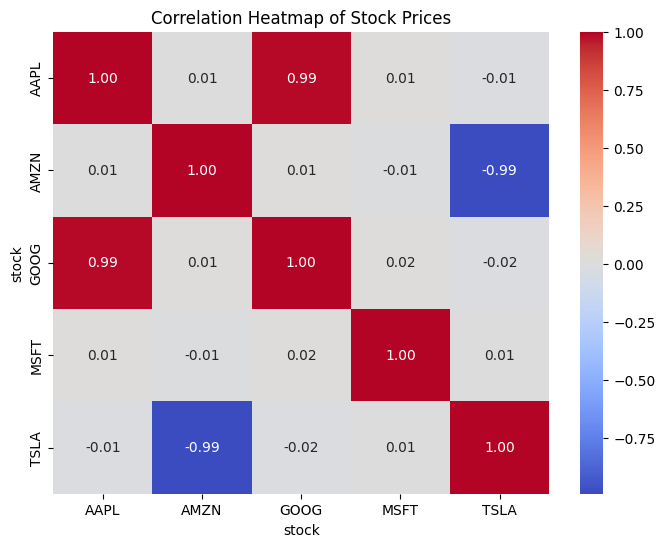

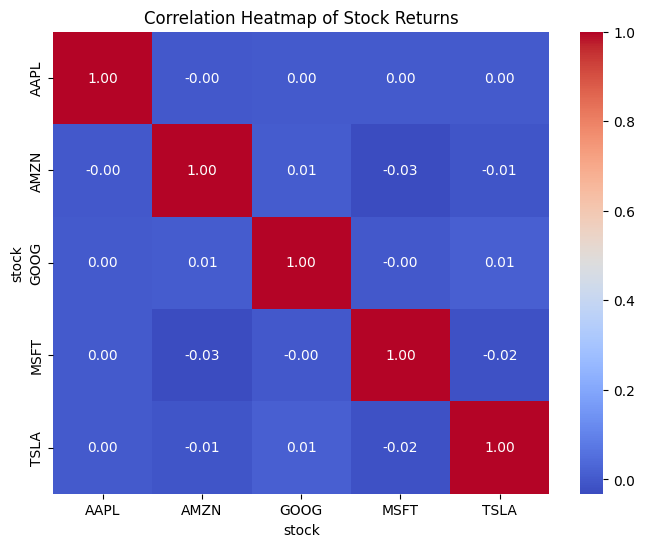

In [36]:
import seaborn as sns



import matplotlib.pyplot as plt

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['price'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Prices")
plt.show()

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['return'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Returns")
plt.show()

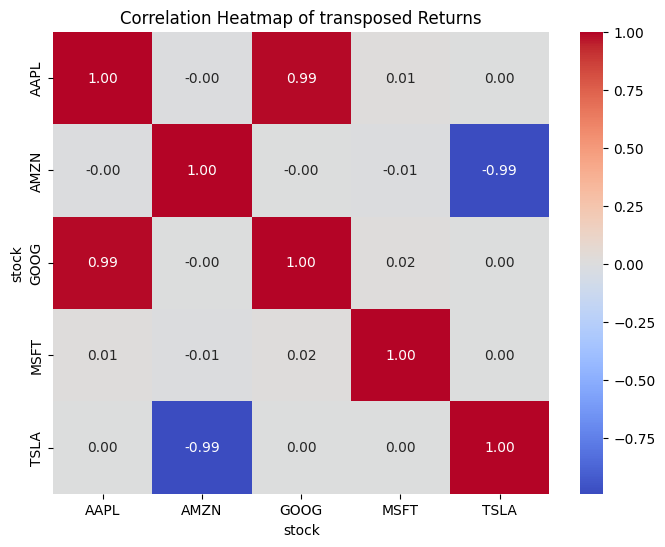

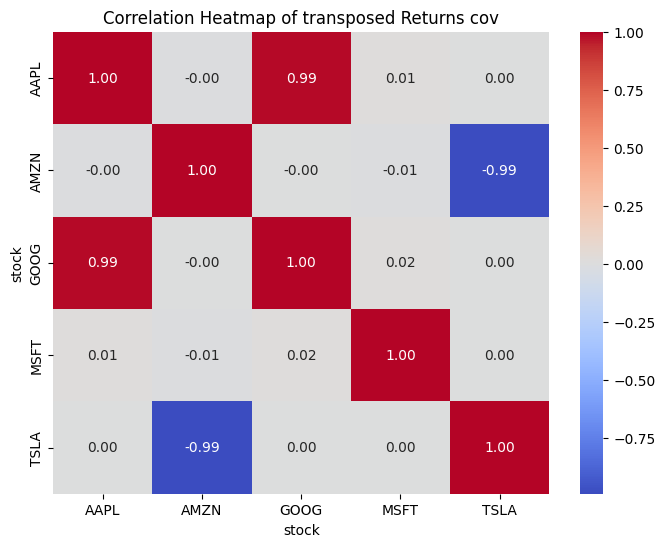

In [37]:

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['transposed_return'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of transposed Returns")
plt.show()


# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['transposed_return_cov'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of transposed Returns cov")
plt.show()

In [39]:
import numpy as np
import pandas as pd

# Example correlation matrix
C = np.array([
    [1.0, 0.9],
    [0.9, 1.0]
])

# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(C)
# Ensure non-negative eigenvalues for sqrt (adjust if needed)
eigenvalues[eigenvalues < 0] = 0
sqrt_eigenvalues = np.sqrt(eigenvalues)
# Construct the transformation matrix
transform_matrix = eigenvectors @ np.diag(sqrt_eigenvalues) @ eigenvectors.T
print("Transform matrix:")
print(transform_matrix)
# Generate uncorrelated random variables
n_samples = 100
uncorrelated = np.random.normal(size=(n_samples, C.shape[0]))

# Generate correlated random variables
correlated = uncorrelated @ transform_matrix.T
print(correlated)
# Convert the correlated array to a pandas DataFrame
correlated_df = pd.DataFrame(correlated, columns=["Var1", "Var2"])

# Compute and print the correlation matrix
print(correlated_df.corr())

Transform matrix:
[[0.84731632 0.53108855]
 [0.53108855 0.84731632]]
[[ 7.63321725e-02 -1.56325209e-01]
 [ 4.90222000e-01 -7.21620487e-02]
 [-6.68564794e-01 -1.16191802e-03]
 [-5.12248602e-01 -4.83901550e-01]
 [-7.82324940e-01 -7.33586892e-01]
 [ 2.07174719e+00  2.15379733e+00]
 [ 2.09986528e+00  1.87696960e+00]
 [-3.65591237e-01 -9.65967628e-01]
 [ 9.86534883e-01  1.72786105e+00]
 [ 4.35035527e-01  1.05160569e+00]
 [-1.37569802e+00 -2.24000486e+00]
 [ 1.21518725e+00  1.41307282e+00]
 [ 6.13344192e-01  1.01876304e+00]
 [-2.14903480e+00 -2.05977532e+00]
 [ 4.26975043e-01  5.13068185e-01]
 [ 1.48877689e+00  1.26183464e+00]
 [-8.98235317e-01 -4.53405715e-01]
 [-4.86378057e-01 -1.26902959e+00]
 [-2.15195399e-01 -3.07517803e-01]
 [-2.89837343e-01  7.49219381e-02]
 [-7.52743983e-01 -2.57353886e-01]
 [ 1.04964025e+00  1.21542968e+00]
 [-1.75130414e+00 -1.87204463e+00]
 [ 8.42842026e-02 -9.44397749e-02]
 [ 2.70296623e+00  1.93005757e+00]
 [-4.25055816e-02 -1.15550928e-01]
 [-7.32612642e-01 -1.